# EDA for DeepFashion2 dataset

### Information on dataset

Each image in seperate image set has a unique six-digit number such as 000001.jpg. A corresponding annotation file in json format is provided in annotation set such as 000001.json.
Each annotation file is organized as below:

source: a string, where 'shop' indicates that the image is from commercial store while 'user' indicates that the image is taken by users.
pair_id: a number. Images from the same shop and their corresponding consumer-taken images have the same pair id.
item 1
category_name: a string which indicates the category of the item.
category_id: a number which corresponds to the category name. In category_id, 1 represents short sleeve top, 2 represents long sleeve top, 3 represents short sleeve outwear, 4 represents long sleeve outwear, 5 represents vest, 6 represents sling, 7 represents shorts, 8 represents trousers, 9 represents skirt, 10 represents short sleeve dress, 11 represents long sleeve dress, 12 represents vest dress and 13 represents sling dress.
style: a number to distinguish between clothing items from images with the same pair id. Clothing items with different style numbers from images with the same pair id have different styles such as color, printing, and logo. In this way, a clothing item from shop images and a clothing item from user image are positive commercial-consumer pair if they have the same style number greater than 0 and they are from images with the same pair id.(If you are confused with style, please refer to issue#10.)
bounding_box: [x1,y1,x2,y2]，where x1 and y_1 represent the upper left point coordinate of bounding box, x_2 and y_2 represent the lower right point coordinate of bounding box. (width=x2-x1;height=y2-y1)
landmarks: [x1,y1,v1,...,xn,yn,vn], where v represents the visibility: v=2 visible; v=1 occlusion; v=0 not labeled. We have different definitions of landmarks for different categories. The orders of landmark annotations are listed in figure 2.
segmentation: [[x1,y1,...xn,yn],[ ]], where [x1,y1,xn,yn] represents a polygon and a single clothing item may contain more than one polygon.
scale: a number, where 1 represents small scale, 2 represents modest scale and 3 represents large scale.
occlusion: a number, where 1 represents slight occlusion(including no occlusion), 2 represents medium occlusion and 3 represents heavy occlusion.
zoom_in: a number, where 1 represents no zoom-in, 2 represents medium zoom-in and 3 represents lagre zoom-in.
viewpoint: a number, where 1 represents no wear, 2 represents frontal viewpoint and 3 represents side or back viewpoint.
item 2
...
item n
Please note that 'pair_id' and 'source' are image-level labels. All clothing items in an image share the same 'pair_id' and 'source'.

The definition of landmarks and skeletons of 13 categories are shown below. The numbers in the figure represent the order of landmark annotations of each category in annotation file. A total of 294 landmarks covering 13 categories are defined.

We do not provide data in pairs. In training dataset, images are organized with continuous 'pair_id' including images from consumers and images from shops. (For example: 000001.jpg(pair_id:1; from consumer), 000002.jpg(pair_id:1; from shop),000003.jpg(pair_id:2; from consumer),000004.jpg(pair_id:2; from consumer),000005.jpg(pair_id:2; from consumer), 000006.jpg(pair_id:2; from consumer),000007.jpg(pair_id:2; from shop),000008.jpg(pair_id:2; from shop)...) A clothing item from shop images and a clothing item from consumer image are positive commercial-consumer pair if they have the same style number which is greater than 0 and they are from images with the same pair id, otherwise they are negative pairs. In this way, you can construct training positive pairs and negative pairs in instance-level.

In [1]:
import os, json
import numpy as np
import pandas as pd
from math import log
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [3]:
train = pd.read_json("/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/train/train.json")

In [4]:
train.head()

,item2,source,pair_id,item1,item3,item4,item6,item5,item8,item7
0,"{'segmentation': [[460, 438, 374, 484, 251, 52...",user,1,"{'segmentation': [[257, 35, 261, 89, 228, 123,...",None,None,None,None,None,None
1,"{'segmentation': [[220.25, 187.55, 259.6, 177....",shop,1,"{'segmentation': [[145.21, 314.0, 162.67, 312....",None,None,None,None,None,None
2,None,user,2,"{'segmentation': [[338, 64, 299, 133, 228, 189...",None,None,None,None,None,None
3,None,user,2,"{'segmentation': [[266, 160, 257, 191, 233, 21...",None,None,None,None,None,None
4,None,user,2,"{'segmentation': [[204.0, 143.0, 182.0, 137.0,...",None,None,None,None,None,None


In [4]:
train.shape

(191953, 10)

In [5]:
train.iloc[0,0]

{'segmentation': [[460,
   438,
   374,
   484,
   251,
   520,
   269,
   586,
   298,
   622,
   410,
   623,
   410,
   567,
   413,
   591,
   420,
   623,
   465,
   622,
   456,
   561,
   466,
   504,
   460,
   438],
  [374, 484, 251, 520, 269, 586, 298, 622, 410, 623, 410, 567, 374, 484],
  [460,
   438,
   374,
   484,
   410,
   567,
   413,
   591,
   420,
   623,
   465,
   622,
   456,
   561,
   466,
   504,
   460,
   438]],
 'scale': 2,
 'viewpoint': 2,
 'zoom_in': 3,
 'landmarks': [251,
  520,
  1,
  374,
  484,
  1,
  460,
  438,
  1,
  269,
  586,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  410,
  567,
  1,
  413,
  591,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  456,
  561,
  2,
  0,
  0,
  0],
 'style': 0,
 'bounding_box': [249, 423, 466, 623],
 'category_id': 8,
 'occlusion': 2,
 'category_name': 'trousers'}

In [12]:
train_temp = train[:100]

In [13]:
temp = pd.json_normalize(train_temp['item1'], max_level=1)

In [14]:
temp_2 = train_temp.join(temp, rsuffix="_item1")
temp_2 = temp_2.drop(columns=['item1'])
temp_2.head()

,item2,source,pair_id,item3,item4,item6,item5,item8,item7,img,segmentation,scale,viewpoint,zoom_in,landmarks,style,bounding_box,category_id,occlusion,category_name
0,"{'segmentation': [[460, 438, 374, 484, 251, 52...",user,1,None,None,None,None,None,None,000001.jpg,"[[257, 35, 261, 89, 228, 123, 137, 103, 45, 91...",3,2,2,"[182, 54, 1, 45, 91, 1, 137, 103, 1, 228, 123,...",1,"[0, 29, 466, 622]",1,2,short sleeve top
1,"{'segmentation': [[220.25, 187.55, 259.6, 177....",shop,1,None,None,None,None,None,None,000002.jpg,"[[145.21, 314.0, 162.67, 312.8, 175.12, 313.05...",3,2,2,"[127, 335, 1, 73, 340, 1, 107, 354, 1, 140, 35...",1,"[1, 300, 367, 701]",1,2,short sleeve top
2,None,user,2,None,None,None,None,None,None,000003.jpg,"[[338, 64, 299, 133, 228, 189, 183, 121, 160, ...",3,1,2,"[240, 108, 2, 160, 63, 2, 183, 121, 2, 228, 18...",1,"[1, 52, 467, 831]",11,1,long sleeve dress
3,None,user,2,None,None,None,None,None,None,000004.jpg,"[[266, 160, 257, 191, 233, 218, 184, 210, 149,...",3,2,2,"[223, 187, 1, 149, 190, 2, 184, 210, 2, 233, 2...",1,"[0, 113, 467, 623]",11,1,long sleeve dress
4,None,user,2,None,None,None,None,None,None,000005.jpg,"[[204.0, 143.0, 182.0, 137.0, 167.0, 130.0, 16...",3,1,2,"[205, 143, 2, 162, 129, 2, 192, 164, 2, 222, 1...",1,"[1, 98, 467, 814]",11,1,long sleeve dress


#### Adding the names of the images for each corresponding row

In [5]:
image_names = os.listdir('./train/image/')
image_names.sort()
image_names[:5]

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']

In [6]:
train["img"] = image_names

In [7]:
train.head()

,item2,source,pair_id,item1,item3,item4,item6,item5,item8,item7,img
0,"{'segmentation': [[460, 438, 374, 484, 251, 52...",user,1,"{'segmentation': [[257, 35, 261, 89, 228, 123,...",None,None,None,None,None,None,000001.jpg
1,"{'segmentation': [[220.25, 187.55, 259.6, 177....",shop,1,"{'segmentation': [[145.21, 314.0, 162.67, 312....",None,None,None,None,None,None,000002.jpg
2,None,user,2,"{'segmentation': [[338, 64, 299, 133, 228, 189...",None,None,None,None,None,None,000003.jpg
3,None,user,2,"{'segmentation': [[266, 160, 257, 191, 233, 21...",None,None,None,None,None,None,000004.jpg
4,None,user,2,"{'segmentation': [[204.0, 143.0, 182.0, 137.0,...",None,None,None,None,None,None,000005.jpg


### Extracting enbedded dict to new columns - full dataset

In [8]:
temp = pd.json_normalize(train['item1'], max_level=1)
temp_2 = train.join(temp)
train_fin = temp_2.drop(columns=['item1'])
train_fin.head()

,item2,source,pair_id,item3,item4,item6,item5,item8,item7,img,segmentation,scale,viewpoint,zoom_in,landmarks,style,bounding_box,category_id,occlusion,category_name
0,"{'segmentation': [[460, 438, 374, 484, 251, 52...",user,1,None,None,None,None,None,None,000001.jpg,"[[257, 35, 261, 89, 228, 123, 137, 103, 45, 91...",3,2,2,"[182, 54, 1, 45, 91, 1, 137, 103, 1, 228, 123,...",1,"[0, 29, 466, 622]",1,2,short sleeve top
1,"{'segmentation': [[220.25, 187.55, 259.6, 177....",shop,1,None,None,None,None,None,None,000002.jpg,"[[145.21, 314.0, 162.67, 312.8, 175.12, 313.05...",3,2,2,"[127, 335, 1, 73, 340, 1, 107, 354, 1, 140, 35...",1,"[1, 300, 367, 701]",1,2,short sleeve top
2,None,user,2,None,None,None,None,None,None,000003.jpg,"[[338, 64, 299, 133, 228, 189, 183, 121, 160, ...",3,1,2,"[240, 108, 2, 160, 63, 2, 183, 121, 2, 228, 18...",1,"[1, 52, 467, 831]",11,1,long sleeve dress
3,None,user,2,None,None,None,None,None,None,000004.jpg,"[[266, 160, 257, 191, 233, 218, 184, 210, 149,...",3,2,2,"[223, 187, 1, 149, 190, 2, 184, 210, 2, 233, 2...",1,"[0, 113, 467, 623]",11,1,long sleeve dress
4,None,user,2,None,None,None,None,None,None,000005.jpg,"[[204.0, 143.0, 182.0, 137.0, 167.0, 130.0, 16...",3,1,2,"[205, 143, 2, 162, 129, 2, 192, 164, 2, 222, 1...",1,"[1, 98, 467, 814]",11,1,long sleeve dress


In [9]:
# Update json to include img names
train_fin.to_json("/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/train.json")

In [11]:
column_desc = ['source',
               'pair_id',
               'scale',
               'viewpoint',
               'zoom_in',
               'style',
               'category_id',
               'occlusion',
               'category_name']

In [12]:
# Remove columns that contain dict values
train_fin.loc[:,column_desc].describe(include='all')

,source,pair_id,scale,viewpoint,zoom_in,style,category_id,occlusion,category_name
count,191961,191961.000000,191961.000000,191961.000000,191961.000000,191961.000000,191961.000000,191961.000000,191961
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
top,shop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,short sleeve top
freq,132157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53916
mean,NaN,7558.112268,2.179187,2.052099,1.370138,1.431593,5.496221,1.490923,NaN
std,NaN,4341.817202,0.712243,0.507312,0.598163,1.247941,4.059728,0.574101,NaN
min,NaN,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,NaN
25%,NaN,3796.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,NaN
50%,NaN,7590.000000,2.000000,2.000000,1.000000,1.000000,5.000000,1.000000,NaN
75%,NaN,11299.000000,3.000000,2.000000,2.000000,2.000000,9.000000,2.000000,NaN


In [13]:
train_fin.isnull().sum()

item2             76107
source                0
pair_id               0
item3            188637
item4            190933
item6            191954
item5            191951
item8            191960
item7            191960
segmentation          0
scale                 0
viewpoint             0
zoom_in               0
landmarks             0
style                 0
bounding_box          0
category_id           0
occlusion             0
category_name         0
dtype: int64

In [14]:
# Counting the number of examples with max number of clothes identified
num_of_clothes = []
column = ['item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8']
item1 = train_fin.shape[0]
num_of_clothes.append(item1)
for i in column:
    temp_i = len(train_fin[i]) - train_fin[i].isnull().values.sum()
    num_of_clothes.append(temp_i)

num_of_clothes

[191961, 115854, 3324, 1028, 10, 7, 1, 1]

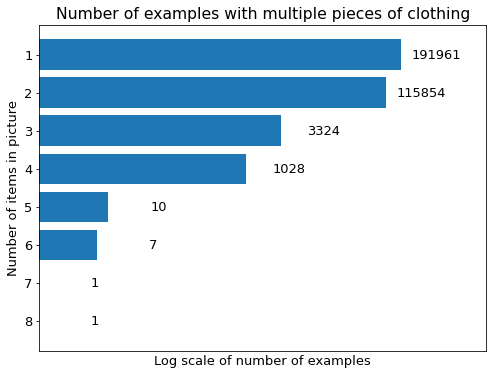

In [177]:
N = range(1, 9)
log_num_clothes = [log(x) for x in num_of_clothes]

plt.rcParams['font.size'] = '13'

fig, ax = plt.subplots(figsize=(8,6))

hbars = ax.barh(N, log_num_clothes, align='center')
ax.set_yticks(range(1, 9))
ax.set_ylabel("Number of items in picture")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Log scale of number of examples')
ax.set_xlim(right=15)
ax.set_xticks([])
ax.set_title('Number of examples with multiple pieces of clothing')

# Label with specially formatted floats
for i in range(len(num_of_clothes)):
    plt.annotate(str(num_of_clothes[i]), xy=(
        log_num_clothes[i]+2, N[i]), ha='right', va='center')


fig.savefig('clothes_per_img.png')
plt.show()

In [15]:
# Looking into col 'catergory_name'
pd.unique(train_fin["category_name"])

array(['short sleeve top', 'long sleeve dress', 'long sleeve top',
       'skirt', 'shorts', 'trousers', 'long sleeve outwear', 'vest dress',
       'short sleeve dress', 'vest', 'short sleeve outwear', 'sling',
       'sling dress'], dtype=object)

In [16]:
train_fin["category_name"].nunique()

13

In [55]:
cat_count = train_fin["category_name"].value_counts()
cat_count

short sleeve top        53916
long sleeve top         25086
trousers                23252
short sleeve dress      16707
vest dress              16122
vest                    12804
shorts                  11999
long sleeve outwear     11138
skirt                    7471
long sleeve dress        7387
sling dress              4027
sling                    1618
short sleeve outwear      434
Name: category_name, dtype: int64

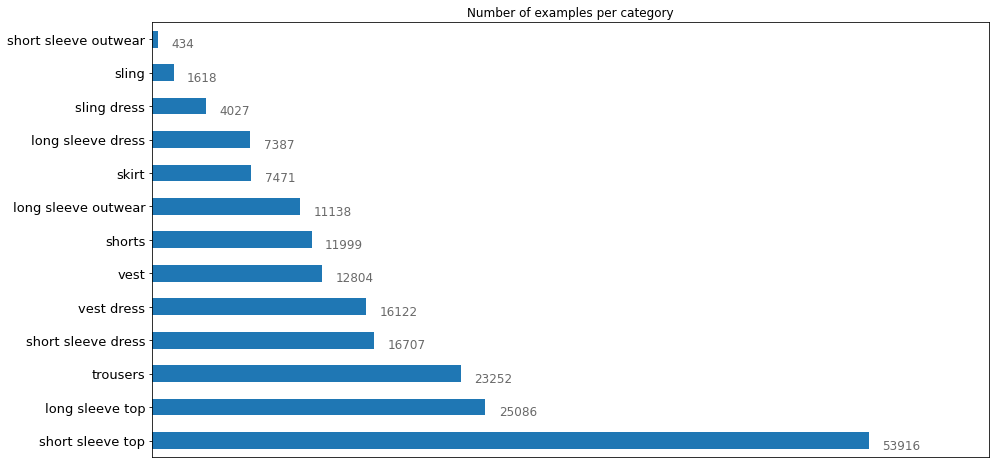

In [167]:
ax = cat_count.plot.barh(figsize=(
    15, 8), title="Number of examples per category", fontsize=13, xticks=[], xlim=(0, 63000))

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+1000, i.get_y(),
            str((i.get_width())*1), fontsize=12,
            color='dimgrey')

fig = ax.get_figure()
fig.savefig("category_graph.png")

In [18]:
# Looking at column 'scale'
pd.unique(train_fin['scale'])

array([3, 1, 2])

In [19]:
train_fin["scale"].value_counts()

2    88418
3    68970
1    34573
Name: scale, dtype: int64

In [20]:
# Looking at column 'viewpoint'
pd.unique(train_fin['viewpoint'])

array([2, 1, 3])

In [21]:
train_fin["viewpoint"].value_counts()

2    142036
3     29963
1     19962
Name: viewpoint, dtype: int64

In [22]:
# Looking at column 'pair_id'
train_fin['pair_id'].nunique()

14555

In [23]:
# Looking at column 'style'
pd.unique(train_fin['style'])

array([ 1,  2,  3,  0,  5,  4,  6,  7,  8,  9, 10, 13, 12, 11, 14, 27, 33,
       15, 32, 22, 26, 21, 17, 16, 25, 23, 30, 24, 28, 19, 20, 31, 18, 29])

In [24]:
train_fin["style"].value_counts()

1     112661
2      36371
0      20395
3      13242
4       4325
5       2428
6        997
7        566
8        306
9        223
10       123
11        84
12        66
13        41
14        37
15        19
16        16
18        15
17        13
19         6
27         4
20         3
21         3
33         2
22         2
23         2
31         2
26         2
30         2
29         1
32         1
28         1
25         1
24         1
Name: style, dtype: int64

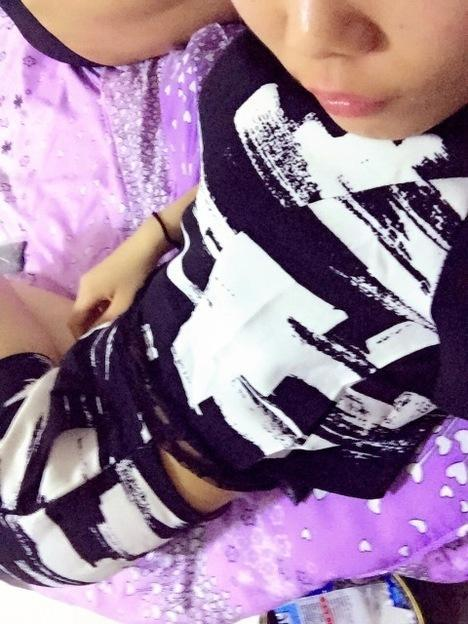

In [25]:
from IPython.display import Image

img_path = '/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/train/image/'

Image(filename= img_path + '000048.jpg')

In [26]:
path_to_json = '/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/train/annos/'
example_json = pd.read_json(path_to_json + "000048.json")
example_json

,item2,source,pair_id,item1
segmentation,"[[248.64, 27.39, 285.0, 69.0, 312.0, 95.0, 346...",user,6,"[[143.83, 418.3, 164.26, 468.94, 189.66, 507.8..."
scale,3,user,6,2
viewpoint,3,user,6,3
zoom_in,2,user,6,2
landmarks,"[399, 44, 1, 342, 27, 1, 330, 62, 1, 357, 99, ...",user,6,"[126, 312, 1, 145, 419, 1, 228, 509, 2, 110, 3..."
style,1,user,6,2
bounding_box,"[104, 21, 467, 509]",user,6,"[0, 297, 237, 597]"
category_id,1,user,6,7
occlusion,2,user,6,3
category_name,short sleeve top,user,6,shorts


In [27]:
train_fin.iloc[47,:]

item2            {'segmentation': [[248.64, 27.39, 285.0, 69.0,...
source                                                        user
pair_id                                                          6
item3                                                         None
item4                                                         None
item6                                                         None
item5                                                         None
item8                                                         None
item7                                                         None
segmentation     [[143.83, 418.3, 164.26, 468.94, 189.66, 507.8...
scale                                                            2
viewpoint                                                        3
zoom_in                                                          2
landmarks        [126, 312, 1, 145, 419, 1, 228, 509, 2, 110, 3...
style                                                         

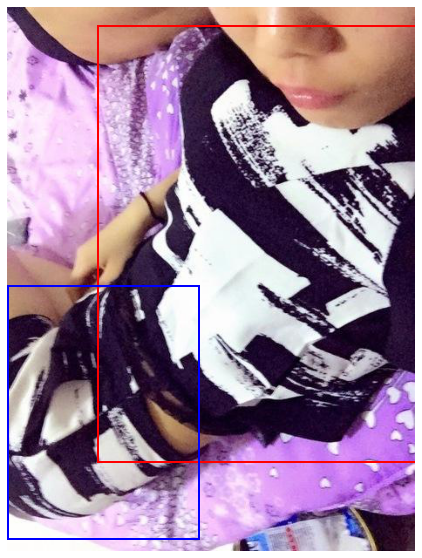

In [175]:
from matplotlib.patches import Rectangle


im = Image.open(img_path + '000048.jpg')

# Display the image
plt.imshow(im)

plt.rcParams["figure.figsize"] = (12,8)
# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
top = Rectangle((104, 21), 370, 500, linewidth=2,
                 edgecolor='r', facecolor='none')
short = Rectangle((0, 320), 220, 290, linewidth = 2,
                 edgecolor = "b", facecolor = "none")

# Add the patch to the Axes
ax.add_patch(top)
ax.add_patch(short)

plt.axis('off')

plt.savefig("test.png", bbox_inches='tight')

plt.show()

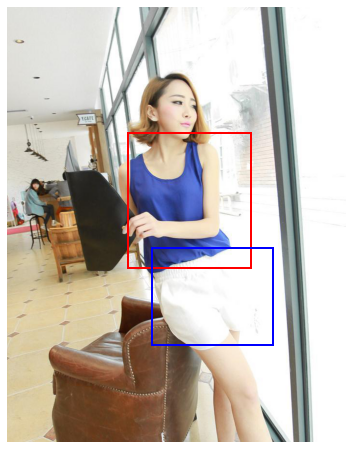

In [176]:
im = Image.open(img_path + '004039.jpg')

# Display the image
plt.imshow(im)

plt.rcParams["figure.figsize"] = (12,8)
# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
top = Rectangle((250, 260), 255, 280, linewidth=2,
                 edgecolor='r', facecolor='none')
short = Rectangle((300, 499), 250, 200, linewidth = 2,
                 edgecolor = "b", facecolor = "none")

# Add the patch to the Axes
ax.add_patch(top)
ax.add_patch(short)

plt.axis('off')

plt.savefig("test_2.png", bbox_inches='tight')

plt.show()

In [125]:
path_to_json = '/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/train/annos/'
example_json = pd.read_json(path_to_json + "004039.json")
example_json

,item2,source,pair_id,item1
segmentation,"[[424, 511, 367, 528, 300, 554, 324, 649, 380,...",shop,317,"[[277, 303, 294, 341, 334, 359, 367, 326, 373,..."
scale,1,shop,317,1
viewpoint,2,shop,317,2
zoom_in,1,shop,317,1
landmarks,"[300, 554, 2, 367, 528, 2, 424, 511, 1, 324, 6...",shop,317,"[331, 343, 1, 277, 303, 2, 294, 341, 2, 334, 3..."
style,0,shop,317,4
bounding_box,"[297, 499, 502, 718]",shop,317,"[250, 274, 468, 553]"
category_id,7,shop,317,5
occlusion,1,shop,317,2
category_name,shorts,shop,317,vest


## Exploring the validation set

In [10]:
val = pd.read_json("/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/validation/validation.json")

In [11]:
val.shape

(32153, 7)

In [12]:
image_val_names = os.listdir('./validation/image/')
image_val_names.sort()
image_val_names[:5]

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']

In [13]:
val['img'] = image_val_names

In [14]:
temp_val = pd.json_normalize(val['item1'], max_level=1)
temp_val2 = val.join(temp_val, rsuffix="_item1")
val_fin = temp_val2.drop(columns=['item1'])
val_fin.head()

,item2,source,pair_id,item3,item4,item5,img,segmentation,scale,viewpoint,zoom_in,landmarks,style,bounding_box,category_id,occlusion,category_name
0,"{'segmentation': [[209.9802276202, 194.9419398...",user,1,None,None,None,000001.jpg,"[[218.9242063492, 189.4996031746, 209.89642857...",1,2,1,"[238, 195, 1, 219, 189, 1, 225, 197, 1, 238, 2...",1,"[199, 190, 287, 269]",5,2,vest
1,"{'segmentation': [[181.1571428571, 133.0142857...",user,1,None,None,None,000002.jpg,"[[194.9765873016, 122.9242063492, 181.60853174...",1,2,1,"[218, 124, 1, 195, 123, 1, 205, 130, 1, 219, 1...",1,"[170, 121, 280, 215]",5,2,vest
2,None,user,3,None,None,None,000003.jpg,"[[222.0721153846, 252.4066086691, 218.07905982...",1,2,1,"[220, 250, 1, 207, 246, 1, 211, 258, 1, 220, 2...",1,"[151, 241, 279, 435]",10,2,short sleeve dress
3,None,user,3,None,None,None,000004.jpg,"[[255.0586538462, 215.8183302808, 242.38266178...",1,3,1,"[255, 217, 1, 275, 214, 1, 0, 0, 0, 0, 0, 0, 0...",1,"[174, 205, 327, 393]",10,1,short sleeve dress
4,None,user,4,None,None,None,000005.jpg,"[[372.7580174927, 63.6168263224, 380.588088296...",3,2,2,"[426, 12, 1, 0, 0, 0, 346, 40, 2, 380, 70, 2, ...",1,"[48, 0, 467, 623]",1,1,short sleeve top


In [15]:
# Update json to include img names
val_fin.to_json("/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/validation.json")

In [188]:
# Counting the number of examples with max number of clothes identified
num_val_clothes = []
column = ['item2', 'item3', 'item4', 'item5']
item1 = val_fin.shape[0]
num_val_clothes.append(item1)
for i in column:
    temp_i = len(val_fin[i]) - val_fin[i].isnull().values.sum()
    num_val_clothes.append(temp_i)

num_val_clothes

[32153, 19469, 682, 184, 2]

In [189]:
val_cat_count = val_fin["category_name"].value_counts()
val_cat_count

short sleeve top        9603
long sleeve top         4414
short sleeve dress      3026
vest dress              2994
trousers                2792
skirt                   2156
vest                    1753
long sleeve outwear     1694
long sleeve dress       1403
shorts                  1200
sling dress              726
sling                    285
short sleeve outwear     107
Name: category_name, dtype: int64

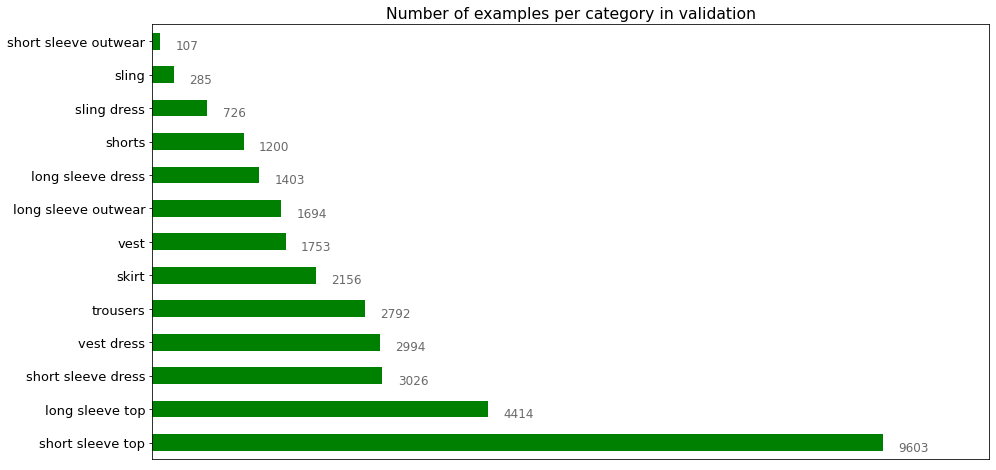

In [195]:
ax = val_cat_count.plot.barh(figsize=(
    15, 8), title="Number of examples per category in validation", fontsize=13, xticks=[], xlim=(0, 11000), color="green")

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+200, i.get_y(),
            str((i.get_width())*1), fontsize=12,
            color='dimgrey')

fig = ax.get_figure()
fig.savefig("category_val_graph.png")

In [182]:
sum(num_val_clothes)

52490

## Building an example training set

In [44]:
train_columns = ['img', 'category_name', 'bounding_box']
train_yolo = train_fin.loc[:, train_columns]
train_yolo.head()

,img,category_name,bounding_box
0,000001.jpg,short sleeve top,"[0, 29, 466, 622]"
1,000002.jpg,short sleeve top,"[1, 300, 367, 701]"
2,000003.jpg,long sleeve dress,"[1, 52, 467, 831]"
3,000004.jpg,long sleeve dress,"[0, 113, 467, 623]"
4,000005.jpg,long sleeve dress,"[1, 98, 467, 814]"


In [45]:
train_yolo.groupby('category_name').count()['img']

category_name
long sleeve dress        7387
long sleeve outwear     11138
long sleeve top         25085
short sleeve dress      16706
short sleeve outwear      434
short sleeve top        53914
shorts                  11999
skirt                    7471
sling                    1618
sling dress              4027
trousers                23250
vest                    12803
vest dress              16121
Name: img, dtype: int64

In [64]:
short_list = ['short sleeve top', 'trousers', 'long sleeve top', 'short sleeve dress']
train_short = train_yolo[train_yolo.category_name.isin(short_list)]
train_short.groupby('category_name').count()['img']

category_name
long sleeve top       25085
short sleeve dress    16706
short sleeve top      53914
trousers              23250
Name: img, dtype: int64

In [66]:
train_short.head()

,img,category_name,bounding_box
0,000001.jpg,short sleeve top,"[0, 29, 466, 622]"
1,000002.jpg,short sleeve top,"[1, 300, 367, 701]"
8,000009.jpg,long sleeve top,"[0, 197, 394, 622]"
9,000010.jpg,long sleeve top,"[0, 190, 466, 516]"
10,000011.jpg,long sleeve top,"[256, 393, 369, 608]"


In [67]:
train_short[['x1', 'y1', 'x2', 'y2']] = pd.DataFrame(
    train_short.bounding_box.tolist(), index=train_short.index)
train_short.head()

/home/jh/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,img,category_name,bounding_box,x1,y1,x2,y2
0,000001.jpg,short sleeve top,"[0, 29, 466, 622]",0,29,466,622
1,000002.jpg,short sleeve top,"[1, 300, 367, 701]",1,300,367,701
8,000009.jpg,long sleeve top,"[0, 197, 394, 622]",0,197,394,622
9,000010.jpg,long sleeve top,"[0, 190, 466, 516]",0,190,466,516
10,000011.jpg,long sleeve top,"[256, 393, 369, 608]",256,393,369,608


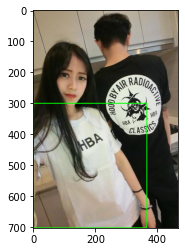

In [68]:
row = train_short.iloc[1].values
image = cv2.imread('./train/image/'+row[0])
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
(x1, y1, x2, y2) = [int(x) for x in row[-4:]]
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

In [51]:
# determine the dimensions of each image
# this is necessary for YOLOv5 training, where we have to specify a "longest" dimension for the training
dims = []
for file in list(train_short['img']):
    i = Image.open('./train/image/'+file)
    dims.append([*i.size])
dims_df = pd.DataFrame(dims, columns=['i_w', 'i_h'])

In [52]:
most_common_w = dims_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
most_common_h = dims_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(most_common_w)
print(most_common_h)

       i_h
i_w       
468  45888
       i_w
i_h       
624  16690


In [69]:
train_short = pd.concat([train_short.reset_index(drop=True), dims_df.reset_index(drop=True)], axis=1)

In [70]:
train_short.head()

,img,category_name,bounding_box,x1,y1,x2,y2,i_w,i_h
0,000001.jpg,short sleeve top,"[0, 29, 466, 622]",0,29,466,622,468,624
1,000002.jpg,short sleeve top,"[1, 300, 367, 701]",1,300,367,701,468,702
2,000009.jpg,long sleeve top,"[0, 197, 394, 622]",0,197,394,622,468,623
3,000010.jpg,long sleeve top,"[0, 190, 466, 516]",0,190,466,516,468,624
4,000011.jpg,long sleeve top,"[256, 393, 369, 608]",256,393,369,608,750,961


In [71]:
most_common_dim = 468

In [72]:
# determine which images are outside the range of the 
# toobig = train_short[(train_short['i_w'] > most_common_dim) | (train_short['i_h'] > most_common_dim)]
toosmall = train_short[(train_short['i_w'] < most_common_dim) & (train_short['i_h'] < most_common_dim)]
print(len(toobig), len(toosmall))

112561 2764


In [73]:
# toobig.groupby('category_name').count()['img'] + 
toosmall.groupby('category_name').count()['img']

category_name
long sleeve top        467
short sleeve dress     759
short sleeve top      1367
trousers               171
Name: img, dtype: int64

In [74]:
# train_short = train_short[~train_short.img.isin(toobig.img)]
train_short = train_short[~train_short.img.isin(toosmall.img)]
train_short.head()

,img,category_name,bounding_box,x1,y1,x2,y2,i_w,i_h
0,000001.jpg,short sleeve top,"[0, 29, 466, 622]",0,29,466,622,468,624
1,000002.jpg,short sleeve top,"[1, 300, 367, 701]",1,300,367,701,468,702
2,000009.jpg,long sleeve top,"[0, 197, 394, 622]",0,197,394,622,468,623
3,000010.jpg,long sleeve top,"[0, 190, 466, 516]",0,190,466,516,468,624
4,000011.jpg,long sleeve top,"[256, 393, 369, 608]",256,393,369,608,750,961


In [75]:
train_short.groupby('category_name').count()['img']

category_name
long sleeve top       24618
short sleeve dress    15947
short sleeve top      52547
trousers              23079
Name: img, dtype: int64

In [76]:
train_short = train_short.groupby('category_name').sample(n=3000, random_state=5)
train_short.groupby('category_name').count()

,img,bounding_box,x1,y1,x2,y2,i_w,i_h
category_name,,,,,,,,
long sleeve top,3000,3000,3000,3000,3000,3000,3000,3000
short sleeve dress,3000,3000,3000,3000,3000,3000,3000,3000
short sleeve top,3000,3000,3000,3000,3000,3000,3000,3000
trousers,3000,3000,3000,3000,3000,3000,3000,3000


In [77]:
train_short['x'] = train_short.apply(lambda row: (((row.x2 - row.x1)/2) + row.x1) / row.i_w, axis=1)
train_short['y'] = train_short.apply(lambda row: (((row.y2 - row.y1)/2) + row.y1) / row.i_h, axis=1)
train_short['w'] = train_short.apply(lambda row: (row.x2 - row.x1) / row.i_w, axis=1)
train_short['h'] = train_short.apply(lambda row: (row.y2 - row.y1) / row.i_h, axis=1)
train_short.head()

,img,category_name,bounding_box,x1,y1,x2,y2,i_w,i_h,x,y,w,h
110385,179133.jpg,long sleeve top,"[91, 248, 466, 623]",91,248,466,623,468,624,0.595085,0.697917,0.801282,0.600962
47799,077865.jpg,long sleeve top,"[200, 296, 573, 711]",200,296,573,711,700,1050,0.552143,0.479524,0.532857,0.395238
22627,036602.jpg,long sleeve top,"[46, 217, 423, 651]",46,217,423,651,468,702,0.501068,0.618234,0.805556,0.618234
62098,100941.jpg,long sleeve top,"[80, 250, 379, 620]",80,250,379,620,468,621,0.490385,0.700483,0.638889,0.595813
89423,145750.jpg,long sleeve top,"[123, 5, 438, 358]",123,5,438,358,640,460,0.438281,0.394565,0.492188,0.767391


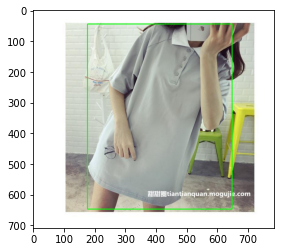

In [78]:
# visually inspect some manually chosen random items
row = train_short.iloc[5000].values
img = cv2.imread('./train/image/'+row[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(i_w, i_h, x, y, w, h) = row[-6:]
# reconstruct the bboxes
x1 = int((x-w/2)*i_w)
y1 = int((y-h/2)*i_h)
x2 = int((x+w/2)*i_w)
y2 = int((y+h/2)*i_h)
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

In [79]:
# create 1 label file for each image
for i, entry in train_short.iterrows():
    # see YOLOv5 pytorch data format:  class x_center y_center width height
    idx = short_list.index(entry.category_name)
    metadata = str(idx)+' ' + ' '.join([str(round(x,3)) for x in entry.iloc[-4:]])    
    filepath = entry.img.split('.')[0]
    fileroot = './test_dataset/train/label/'+filepath
    
    if not os.path.exists(os.path.dirname(fileroot)):
        try:
            os.makedirs(os.path.dirname(fileroot))
        except: # Guard against race condition
            print(problem)
            raise
    
    f = open(fileroot+'.txt', 'w')
    f.write(metadata)
    f.close()

In [80]:
path = os.getcwd()

In [16]:
train_list = list(train_short['img'])
train_list[:5]

NameError: name 'train_short' is not defined

In [90]:
import shutil

dir_src = (path + '/train/image/')
dir_dst = ("/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/test_dataset/train/image/")

# Copy image files to new directory
for file in train_list:
    if file.endswith('.jpg'):
        shutil.copy(dir_src + file, dir_dst)
    print(file)

179133.jpg
077865.jpg
036602.jpg
100941.jpg
145750.jpg
191057.jpg
043176.jpg
087735.jpg
097605.jpg
188842.jpg
138286.jpg
051589.jpg
067686.jpg
173568.jpg
139052.jpg
023673.jpg
044419.jpg
106614.jpg
152253.jpg
046908.jpg
047224.jpg
176106.jpg
116671.jpg
005130.jpg
133017.jpg
104376.jpg
169618.jpg
132227.jpg
147689.jpg
174016.jpg
147499.jpg
061335.jpg
144693.jpg
053254.jpg
122911.jpg
092912.jpg
129101.jpg
021018.jpg
003716.jpg
006372.jpg
073398.jpg
134705.jpg
049801.jpg
009327.jpg
173794.jpg
144753.jpg
062935.jpg
164594.jpg
028333.jpg
050924.jpg
025985.jpg
134952.jpg
105085.jpg
153367.jpg
157061.jpg
028163.jpg
157330.jpg
089689.jpg
024947.jpg
060875.jpg
172136.jpg
106521.jpg
003905.jpg
135304.jpg
062893.jpg
123234.jpg
191906.jpg
122180.jpg
063118.jpg
104081.jpg
085998.jpg
110542.jpg
140313.jpg
051590.jpg
043020.jpg
126338.jpg
129851.jpg
017878.jpg
075628.jpg
044339.jpg
048499.jpg
124750.jpg
160899.jpg
002220.jpg
176934.jpg
128033.jpg
132219.jpg
092604.jpg
044636.jpg
123000.jpg
019961.jpg

069220.jpg
065041.jpg
143595.jpg
164595.jpg
012472.jpg
031660.jpg
023708.jpg
061793.jpg
179983.jpg
079585.jpg
155842.jpg
189306.jpg
036459.jpg
026717.jpg
081301.jpg
003166.jpg
096222.jpg
069312.jpg
134524.jpg
072102.jpg
139231.jpg
020644.jpg
166029.jpg
096978.jpg
183431.jpg
045044.jpg
032898.jpg
132213.jpg
176936.jpg
083440.jpg
085879.jpg
169399.jpg
079881.jpg
025659.jpg
053819.jpg
023427.jpg
077108.jpg
015212.jpg
077602.jpg
141904.jpg
028535.jpg
107815.jpg
015529.jpg
105115.jpg
152182.jpg
162091.jpg
187900.jpg
054731.jpg
096662.jpg
061606.jpg
031583.jpg
178671.jpg
121015.jpg
044484.jpg
071835.jpg
060874.jpg
161640.jpg
044331.jpg
152389.jpg
169169.jpg
172049.jpg
088722.jpg
075010.jpg
170109.jpg
146035.jpg
043177.jpg
038613.jpg
063944.jpg
035847.jpg
008189.jpg
103856.jpg
147540.jpg
116075.jpg
063159.jpg
009445.jpg
113111.jpg
015701.jpg
140892.jpg
135442.jpg
021079.jpg
124329.jpg
084807.jpg
118065.jpg
136909.jpg
056998.jpg
016342.jpg
124757.jpg
079884.jpg
116990.jpg
047199.jpg
096966.jpg

119810.jpg
013536.jpg
120503.jpg
089728.jpg
189541.jpg
063954.jpg
027078.jpg
183092.jpg
144707.jpg
148584.jpg
092395.jpg
073777.jpg
014113.jpg
098202.jpg
124301.jpg
071670.jpg
021369.jpg
034380.jpg
173177.jpg
163269.jpg
152012.jpg
108668.jpg
040216.jpg
133805.jpg
081024.jpg
099907.jpg
063874.jpg
115393.jpg
188929.jpg
002436.jpg
081690.jpg
078365.jpg
047767.jpg
135295.jpg
052722.jpg
169421.jpg
168886.jpg
153044.jpg
033336.jpg
075935.jpg
054001.jpg
115267.jpg
110842.jpg
036600.jpg
126118.jpg
010220.jpg
059731.jpg
047762.jpg
051275.jpg
002919.jpg
139600.jpg
047749.jpg
173186.jpg
082504.jpg
146837.jpg
049092.jpg
183093.jpg
136582.jpg
142658.jpg
149845.jpg
098167.jpg
144282.jpg
131166.jpg
005157.jpg
013625.jpg
034958.jpg
097017.jpg
002200.jpg
044773.jpg
104085.jpg
116881.jpg
088190.jpg
108875.jpg
179994.jpg
181187.jpg
097392.jpg
108861.jpg
003945.jpg
001549.jpg
001050.jpg
016167.jpg
173899.jpg
113129.jpg
021148.jpg
083290.jpg
148227.jpg
067603.jpg
162087.jpg
172889.jpg
191209.jpg
015379.jpg

103846.jpg
088720.jpg
115268.jpg
084981.jpg
059038.jpg
035408.jpg
052057.jpg
025104.jpg
170201.jpg
040305.jpg
055836.jpg
134566.jpg
183777.jpg
161416.jpg
077333.jpg
047725.jpg
188368.jpg
042183.jpg
146268.jpg
097385.jpg
114675.jpg
096052.jpg
045686.jpg
046584.jpg
069099.jpg
090354.jpg
113400.jpg
139964.jpg
145436.jpg
070049.jpg
088667.jpg
134681.jpg
191312.jpg
061717.jpg
080926.jpg
136097.jpg
178672.jpg
128988.jpg
058563.jpg
021351.jpg
015180.jpg
120880.jpg
133799.jpg
021546.jpg
002098.jpg
052321.jpg
161447.jpg
176733.jpg
049937.jpg
125332.jpg
116865.jpg
164382.jpg
173157.jpg
108863.jpg
098204.jpg
164119.jpg
144284.jpg
121323.jpg
110072.jpg
040592.jpg
065583.jpg
128331.jpg
012702.jpg
061735.jpg
185847.jpg
046408.jpg
020639.jpg
113949.jpg
109601.jpg
050731.jpg
086007.jpg
030695.jpg
155872.jpg
176663.jpg
180738.jpg
020631.jpg
103839.jpg
143122.jpg
098450.jpg
052792.jpg
153347.jpg
014022.jpg
128365.jpg
058678.jpg
064212.jpg
089758.jpg
051802.jpg
094222.jpg
049613.jpg
008188.jpg
059143.jpg

138346.jpg
188011.jpg
012945.jpg
066068.jpg
092052.jpg
070797.jpg
063173.jpg
151167.jpg
068899.jpg
142366.jpg
183917.jpg
182923.jpg
017148.jpg
120102.jpg
072309.jpg
112864.jpg
134940.jpg
018864.jpg
080302.jpg
067408.jpg
007820.jpg
134605.jpg
013186.jpg
138227.jpg
050864.jpg
137141.jpg
038535.jpg
032331.jpg
114902.jpg
081197.jpg
108696.jpg
090882.jpg
175704.jpg
087298.jpg
004315.jpg
106383.jpg
017535.jpg
086516.jpg
025186.jpg
135322.jpg
016424.jpg
190509.jpg
038841.jpg
112859.jpg
061167.jpg
164943.jpg
103448.jpg
110997.jpg
155578.jpg
149046.jpg
160297.jpg
096924.jpg
122410.jpg
125972.jpg
050127.jpg
029367.jpg
064277.jpg
065143.jpg
035828.jpg
174180.jpg
136005.jpg
161855.jpg
127455.jpg
176264.jpg
109243.jpg
114698.jpg
037245.jpg
137386.jpg
085672.jpg
078960.jpg
131268.jpg
041870.jpg
081155.jpg
124218.jpg
042509.jpg
185656.jpg
045158.jpg
190936.jpg
166988.jpg
102224.jpg
041857.jpg
180782.jpg
009430.jpg
190434.jpg
010052.jpg
045163.jpg
050908.jpg
116949.jpg
067937.jpg
078969.jpg
005473.jpg

074249.jpg
078549.jpg
065092.jpg
028441.jpg
054662.jpg
182568.jpg
002720.jpg
166586.jpg
083951.jpg
110381.jpg
168149.jpg
067622.jpg
091895.jpg
024518.jpg
020210.jpg
047128.jpg
079296.jpg
086676.jpg
047332.jpg
167605.jpg
045490.jpg
055971.jpg
117155.jpg
173863.jpg
137158.jpg
054279.jpg
118523.jpg
122681.jpg
015010.jpg
093721.jpg
016447.jpg
121880.jpg
116604.jpg
187759.jpg
158371.jpg
029370.jpg
138971.jpg
178227.jpg
049574.jpg
138650.jpg
071735.jpg
174880.jpg
062912.jpg
029402.jpg
074370.jpg
141380.jpg
116931.jpg
001113.jpg
176809.jpg
140197.jpg
078976.jpg
160194.jpg
169537.jpg
155330.jpg
040371.jpg
060817.jpg
028454.jpg
123929.jpg
187239.jpg
067079.jpg
122136.jpg
177942.jpg
020876.jpg
090885.jpg
138158.jpg
101494.jpg
162002.jpg
115612.jpg
096305.jpg
079858.jpg
050860.jpg
067621.jpg
039067.jpg
003282.jpg
031989.jpg
041195.jpg
119434.jpg
100040.jpg
041206.jpg
033365.jpg
169984.jpg
183234.jpg
029403.jpg
147148.jpg
153067.jpg
081898.jpg
083953.jpg
169521.jpg
137338.jpg
022964.jpg
187226.jpg

147107.jpg
135173.jpg
121007.jpg
102229.jpg
047337.jpg
136810.jpg
092063.jpg
010447.jpg
034679.jpg
129664.jpg
067875.jpg
179342.jpg
089060.jpg
071329.jpg
039908.jpg
187753.jpg
124818.jpg
024282.jpg
104518.jpg
076500.jpg
170778.jpg
089071.jpg
133884.jpg
115936.jpg
021000.jpg
025324.jpg
001778.jpg
050047.jpg
029749.jpg
077471.jpg
114706.jpg
090695.jpg
107243.jpg
090696.jpg
003473.jpg
096835.jpg
016115.jpg
005495.jpg
005490.jpg
013244.jpg
131195.jpg
109281.jpg
175701.jpg
097648.jpg
046310.jpg
151175.jpg
138858.jpg
110769.jpg
129295.jpg
083958.jpg
165432.jpg
063672.jpg
014116.jpg
173472.jpg
156009.jpg
013481.jpg
118374.jpg
100058.jpg
022965.jpg
051286.jpg
176258.jpg
084773.jpg
007484.jpg
030728.jpg
155586.jpg
145225.jpg
177289.jpg
092541.jpg
179712.jpg
138879.jpg
174610.jpg
099509.jpg
153083.jpg
074658.jpg
086955.jpg
141191.jpg
167671.jpg
190223.jpg
175331.jpg
032871.jpg
114904.jpg
021539.jpg
178225.jpg
146597.jpg
119451.jpg
005494.jpg
129882.jpg
006141.jpg
097681.jpg
118018.jpg
024022.jpg

100352.jpg
119994.jpg
036225.jpg
077241.jpg
097711.jpg
190155.jpg
006046.jpg
009906.jpg
182804.jpg
163615.jpg
172831.jpg
145238.jpg
135105.jpg
092463.jpg
048708.jpg
139261.jpg
096459.jpg
139441.jpg
102180.jpg
122126.jpg
139011.jpg
164896.jpg
145243.jpg
010131.jpg
074070.jpg
161859.jpg
060829.jpg
030899.jpg
011666.jpg
045491.jpg
077163.jpg
072394.jpg
074516.jpg
039911.jpg
137342.jpg
181472.jpg
100564.jpg
123930.jpg
013479.jpg
179237.jpg
044598.jpg
004667.jpg
110889.jpg
037833.jpg
013861.jpg
179334.jpg
015011.jpg
191722.jpg
122618.jpg
060285.jpg
174182.jpg
013221.jpg
063577.jpg
089772.jpg
146985.jpg
114704.jpg
175048.jpg
124055.jpg
013172.jpg
105912.jpg
170771.jpg
113301.jpg
030178.jpg
113516.jpg
083956.jpg
078123.jpg
051292.jpg
070295.jpg
067925.jpg
129508.jpg
102231.jpg
032333.jpg
073860.jpg
169535.jpg
088261.jpg
055392.jpg
128974.jpg
036175.jpg
103751.jpg
040961.jpg
131584.jpg
099260.jpg
098606.jpg
090813.jpg
177281.jpg
156806.jpg
056975.jpg
037857.jpg
183845.jpg
179648.jpg
090876.jpg

073752.jpg
000110.jpg
031271.jpg
069694.jpg
159468.jpg
154351.jpg
132775.jpg
171764.jpg
088760.jpg
080125.jpg
104616.jpg
044551.jpg
103657.jpg
149160.jpg
016760.jpg
182173.jpg
094728.jpg
160782.jpg
077961.jpg
051423.jpg
064900.jpg
122891.jpg
075543.jpg
040735.jpg
012726.jpg
167409.jpg
072859.jpg
189801.jpg
008886.jpg
071992.jpg
171970.jpg
056742.jpg
025701.jpg
119669.jpg
178390.jpg
009739.jpg
130790.jpg
036965.jpg
155799.jpg
029576.jpg
083599.jpg
122402.jpg
043253.jpg
100388.jpg
077331.jpg
171553.jpg
019509.jpg
115309.jpg
181283.jpg
091921.jpg
159065.jpg
091083.jpg
037455.jpg
104334.jpg
069833.jpg
108469.jpg
009958.jpg
080314.jpg
041971.jpg
057584.jpg
116345.jpg
056664.jpg
055876.jpg
063116.jpg
003002.jpg
116456.jpg
066144.jpg
072030.jpg
137839.jpg
042304.jpg
092565.jpg
141838.jpg
154691.jpg
177566.jpg
123337.jpg
162630.jpg
027826.jpg
145498.jpg
036259.jpg
129951.jpg
141570.jpg
096518.jpg
152652.jpg
045821.jpg
005892.jpg
037342.jpg
186419.jpg
079989.jpg
007440.jpg
119351.jpg
108172.jpg

132557.jpg
142617.jpg
028933.jpg
034514.jpg
133025.jpg
106565.jpg
014873.jpg
016753.jpg
094844.jpg
027926.jpg
148532.jpg
169747.jpg
150894.jpg
043216.jpg
103629.jpg
104133.jpg
130746.jpg
048379.jpg
107027.jpg
138612.jpg
083548.jpg
184262.jpg
154355.jpg
158435.jpg
088129.jpg
180158.jpg
007841.jpg
004238.jpg
064898.jpg
069497.jpg
102242.jpg
021982.jpg
048219.jpg
164299.jpg
055216.jpg
056203.jpg
102473.jpg
033186.jpg
022290.jpg
003016.jpg
156170.jpg
101836.jpg
111284.jpg
087499.jpg
095378.jpg
038514.jpg
031238.jpg
022456.jpg
040423.jpg
126681.jpg
025697.jpg
015279.jpg
078678.jpg
046495.jpg
052968.jpg
066123.jpg
132777.jpg
020044.jpg
187298.jpg
020038.jpg
083080.jpg
068439.jpg
012241.jpg
011487.jpg
153529.jpg
113588.jpg
132817.jpg
126181.jpg
132082.jpg
172084.jpg
014267.jpg
043211.jpg
170097.jpg
031203.jpg
130709.jpg
102685.jpg
135923.jpg
138571.jpg
007402.jpg
046983.jpg
020790.jpg
150876.jpg
118625.jpg
107552.jpg
184096.jpg
181352.jpg
152440.jpg
079187.jpg
001850.jpg
143957.jpg
154592.jpg

084108.jpg
044140.jpg
175840.jpg
106368.jpg
092744.jpg
162383.jpg
130682.jpg
034682.jpg
068402.jpg
042840.jpg
139658.jpg
095030.jpg
050619.jpg
066253.jpg
063849.jpg
121786.jpg
190958.jpg
155213.jpg
139530.jpg
158924.jpg
083303.jpg
029084.jpg
079691.jpg
010013.jpg
062172.jpg
149147.jpg
074158.jpg
032992.jpg
011646.jpg
134049.jpg
036266.jpg
118899.jpg
135926.jpg
101021.jpg
167678.jpg
133334.jpg
133306.jpg
053355.jpg
159733.jpg
189230.jpg
172571.jpg
029500.jpg
161687.jpg
096694.jpg
158617.jpg
011059.jpg
155112.jpg
049920.jpg
053930.jpg
052332.jpg
134660.jpg
169382.jpg
047537.jpg
048889.jpg
085627.jpg
071850.jpg
026525.jpg
124453.jpg
172939.jpg
022380.jpg
111408.jpg
051740.jpg
009114.jpg
164072.jpg
044145.jpg
178542.jpg
083806.jpg
181933.jpg
118892.jpg
099505.jpg
025969.jpg
126869.jpg
090171.jpg
178975.jpg
027180.jpg
054523.jpg
017582.jpg
160800.jpg
101710.jpg
181126.jpg
070906.jpg
148898.jpg
003317.jpg
188338.jpg
013291.jpg
013909.jpg
153411.jpg
127609.jpg
017757.jpg
018568.jpg
115061.jpg

068867.jpg
111030.jpg
093156.jpg
125649.jpg
031446.jpg
027679.jpg
172056.jpg
037903.jpg
001854.jpg
189028.jpg
008587.jpg
007456.jpg
188171.jpg
026911.jpg
051973.jpg
186056.jpg
093869.jpg
009811.jpg
079062.jpg
120911.jpg
059303.jpg
042145.jpg
030212.jpg
162824.jpg
003628.jpg
186604.jpg
181317.jpg
156519.jpg
049054.jpg
105062.jpg
039164.jpg
148543.jpg
034362.jpg
090000.jpg
046498.jpg
051055.jpg
002624.jpg
149214.jpg
125381.jpg
125304.jpg
029304.jpg
048850.jpg
080748.jpg
079027.jpg
087474.jpg
054404.jpg
153460.jpg
125416.jpg
163642.jpg
187309.jpg
074547.jpg
023641.jpg
113046.jpg
078643.jpg
056149.jpg
148510.jpg
148242.jpg
099006.jpg
104114.jpg
172946.jpg
028857.jpg
144932.jpg
016566.jpg
150627.jpg
045195.jpg
160266.jpg
068518.jpg
100381.jpg
064186.jpg
170868.jpg
099317.jpg
178412.jpg
055244.jpg
039261.jpg
053161.jpg
167403.jpg
119348.jpg
062161.jpg
070221.jpg
101636.jpg
148333.jpg
091483.jpg
079209.jpg
031453.jpg
190186.jpg
182827.jpg
040675.jpg
173518.jpg
016205.jpg
074167.jpg
186223.jpg

092096.jpg
147480.jpg
069387.jpg
121174.jpg
191338.jpg
039583.jpg
137401.jpg
044195.jpg
127275.jpg
101165.jpg
018541.jpg
122279.jpg
034805.jpg
110727.jpg
037704.jpg
020816.jpg
104450.jpg
166080.jpg
159472.jpg
042697.jpg
011604.jpg
114415.jpg
109724.jpg
121724.jpg
105794.jpg
176899.jpg
075531.jpg
021700.jpg
158438.jpg
033702.jpg
157096.jpg
173462.jpg
055084.jpg
076819.jpg
007898.jpg
124916.jpg
112810.jpg
059862.jpg
098903.jpg
108804.jpg
161165.jpg
140585.jpg
064612.jpg
036393.jpg
019003.jpg
002993.jpg
068013.jpg
154570.jpg
053040.jpg
001671.jpg
062880.jpg
133663.jpg
083688.jpg
031495.jpg
164790.jpg
128245.jpg
128764.jpg
029963.jpg
082699.jpg
106172.jpg
099796.jpg
106807.jpg
056253.jpg
070775.jpg
114199.jpg
079360.jpg
027337.jpg
123975.jpg
184162.jpg
128879.jpg
059798.jpg
150068.jpg
153692.jpg
179888.jpg
017802.jpg
098706.jpg
152911.jpg
019400.jpg
056271.jpg
155361.jpg
178368.jpg
073718.jpg
019480.jpg
078791.jpg
018747.jpg
124693.jpg
116496.jpg
097480.jpg
095518.jpg
050395.jpg
026738.jpg

179293.jpg
129065.jpg
001152.jpg
166363.jpg
185568.jpg
074844.jpg
077712.jpg
012647.jpg
075749.jpg
106544.jpg
015152.jpg
158250.jpg
106831.jpg
164502.jpg
181776.jpg
096388.jpg
033520.jpg
071787.jpg
127852.jpg
095853.jpg
047569.jpg
155349.jpg
151901.jpg
133503.jpg
069177.jpg
055066.jpg
129398.jpg
124797.jpg
058522.jpg
123113.jpg
086122.jpg
129063.jpg
066544.jpg
100679.jpg
184833.jpg
012564.jpg
007669.jpg
051130.jpg
099804.jpg
042938.jpg
022341.jpg
001815.jpg
014065.jpg
044224.jpg
076023.jpg
032451.jpg
023865.jpg
057036.jpg
092537.jpg
010957.jpg
073457.jpg
159596.jpg
053543.jpg
159587.jpg
055425.jpg
018219.jpg
170135.jpg
102917.jpg
064618.jpg
074486.jpg
107328.jpg
024224.jpg
012572.jpg
091090.jpg
058361.jpg
087343.jpg
020327.jpg
010325.jpg
130468.jpg
176093.jpg
044404.jpg
068812.jpg
155362.jpg
041581.jpg
107579.jpg
062053.jpg
071492.jpg
016427.jpg
088421.jpg
085911.jpg
145949.jpg
005836.jpg
093468.jpg
010529.jpg
031318.jpg
079492.jpg
171656.jpg
077619.jpg
084388.jpg
171731.jpg
057093.jpg

047008.jpg
050569.jpg
112811.jpg
159597.jpg
188971.jpg
019623.jpg
011691.jpg
101167.jpg
029045.jpg
038954.jpg
130547.jpg
034338.jpg
158440.jpg
137279.jpg
033347.jpg
055189.jpg
009613.jpg
057899.jpg
007828.jpg
081798.jpg
048852.jpg
029946.jpg
095983.jpg
163292.jpg
109104.jpg
104322.jpg
079487.jpg
187404.jpg
146806.jpg
174410.jpg
038962.jpg
177622.jpg
129030.jpg
020844.jpg
008004.jpg
013829.jpg
107972.jpg
079826.jpg
078342.jpg
149690.jpg
163978.jpg
142596.jpg
062106.jpg
121464.jpg
138586.jpg
098626.jpg
102878.jpg
008109.jpg
151505.jpg
061940.jpg
181889.jpg
059809.jpg
060553.jpg
026698.jpg
096568.jpg
071862.jpg
021269.jpg
144252.jpg
066879.jpg
167985.jpg
107785.jpg
056651.jpg
076931.jpg
139243.jpg
066644.jpg
031589.jpg
157416.jpg
078767.jpg
162463.jpg
019406.jpg
150341.jpg
168898.jpg
077928.jpg
116021.jpg
092536.jpg
065129.jpg
191105.jpg
174269.jpg
010741.jpg
006104.jpg
117574.jpg
183015.jpg
102877.jpg
137412.jpg
175272.jpg
076303.jpg
186479.jpg
125593.jpg
095285.jpg
179432.jpg
033651.jpg

113737.jpg
070857.jpg
108479.jpg
043451.jpg
168003.jpg
164362.jpg
148042.jpg
155717.jpg
014605.jpg
149585.jpg
079794.jpg
177636.jpg
044256.jpg
125284.jpg
183776.jpg
116154.jpg
114501.jpg
003130.jpg
123626.jpg
065574.jpg
016518.jpg
143670.jpg
070785.jpg
102891.jpg
012857.jpg
191427.jpg
002856.jpg
029690.jpg
034905.jpg
018687.jpg
055321.jpg
124695.jpg
053547.jpg
106287.jpg
031400.jpg
015322.jpg
007668.jpg
043439.jpg
172695.jpg
019636.jpg
021684.jpg
062881.jpg
180408.jpg
080064.jpg
016925.jpg
191632.jpg
178540.jpg
178888.jpg
022858.jpg
158092.jpg
018283.jpg
085810.jpg
125197.jpg
179910.jpg
175228.jpg
001670.jpg
048302.jpg
043236.jpg
075080.jpg
080387.jpg
062849.jpg
153675.jpg
176485.jpg
019644.jpg
040134.jpg
095961.jpg
051033.jpg
071867.jpg
079838.jpg
122097.jpg
064673.jpg
006230.jpg
066877.jpg
181763.jpg
139572.jpg
003957.jpg
113686.jpg
107804.jpg
140105.jpg
074968.jpg
114426.jpg
010615.jpg
113368.jpg
117873.jpg
035376.jpg
111066.jpg
001309.jpg
126617.jpg
168450.jpg
175565.jpg
012202.jpg

### Making validation test set

In [89]:
val_columns = ['img', 'category_name', 'bounding_box']
val_yolo = val_fin.loc[:, val_columns]
val_yolo.head()

,img,category_name,bounding_box
0,000001.jpg,vest,"[199, 190, 287, 269]"
1,000002.jpg,vest,"[170, 121, 280, 215]"
2,000003.jpg,short sleeve dress,"[151, 241, 279, 435]"
3,000004.jpg,short sleeve dress,"[174, 205, 327, 393]"
4,000005.jpg,short sleeve top,"[48, 0, 467, 623]"


In [91]:
val_yolo.groupby('category_name').count()['img']

category_name
long sleeve dress       1403
long sleeve outwear     1694
long sleeve top         4414
short sleeve dress      3026
short sleeve outwear     107
short sleeve top        9603
shorts                  1200
skirt                   2156
sling                    285
sling dress              726
trousers                2792
vest                    1753
vest dress              2994
Name: img, dtype: int64

In [92]:
val_short = val_yolo[val_yolo.category_name.isin(short_list)]
val_short.groupby('category_name').count()['img']

category_name
long sleeve top       4414
short sleeve dress    3026
short sleeve top      9603
trousers              2792
Name: img, dtype: int64

In [93]:
val_short[['x1', 'y1', 'x2', 'y2']] = pd.DataFrame(
    val_short.bounding_box.tolist(), index=val_short.index)
val_short.head()

/home/jh/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,img,category_name,bounding_box,x1,y1,x2,y2
2,000003.jpg,short sleeve dress,"[151, 241, 279, 435]",151,241,279,435
3,000004.jpg,short sleeve dress,"[174, 205, 327, 393]",174,205,327,393
4,000005.jpg,short sleeve top,"[48, 0, 467, 623]",48,0,467,623
9,000010.jpg,short sleeve dress,"[1, 22, 255, 623]",1,22,255,623
10,000011.jpg,short sleeve dress,"[0, 0, 467, 466]",0,0,467,466


In [94]:
# determine the dimensions of each image
# this is necessary for YOLOv5 training, where we have to specify a "longest" dimension for the training
val_dim = []
for file in list(val_short['img']):
    i = Image.open('./validation/image/'+file)
    val_dim.append([*i.size])
val_dim_df = pd.DataFrame(val_dim, columns=['i_w', 'i_h'])

In [95]:
val_w = val_dim_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
val_h = val_dim_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(val_w)
print(val_h)

      i_h
i_w      
468  7928
      i_w
i_h      
624  2827


In [96]:
val_short = pd.concat([val_short.reset_index(drop=True), val_dim_df.reset_index(drop=True)], axis=1)

In [97]:
val_short.head()

,img,category_name,bounding_box,x1,y1,x2,y2,i_w,i_h
0,000003.jpg,short sleeve dress,"[151, 241, 279, 435]",151,241,279,435,468,628
1,000004.jpg,short sleeve dress,"[174, 205, 327, 393]",174,205,327,393,468,632
2,000005.jpg,short sleeve top,"[48, 0, 467, 623]",48,0,467,623,468,624
3,000010.jpg,short sleeve dress,"[1, 22, 255, 623]",1,22,255,623,468,624
4,000011.jpg,short sleeve dress,"[0, 0, 467, 466]",0,0,467,466,468,624


In [99]:
valtoosmall = val_short[(val_short['i_w'] < most_common_dim) & (val_short['i_h'] < most_common_dim)]
print(len(valtoosmall))

299


In [100]:
valtoosmall.groupby('category_name').count()['img']

category_name
long sleeve top        29
short sleeve dress     94
short sleeve top      152
trousers               24
Name: img, dtype: int64

In [101]:
val_short = val_short[~val_short.img.isin(valtoosmall.img)]
val_short.head()

,img,category_name,bounding_box,x1,y1,x2,y2,i_w,i_h
0,000003.jpg,short sleeve dress,"[151, 241, 279, 435]",151,241,279,435,468,628
1,000004.jpg,short sleeve dress,"[174, 205, 327, 393]",174,205,327,393,468,632
2,000005.jpg,short sleeve top,"[48, 0, 467, 623]",48,0,467,623,468,624
3,000010.jpg,short sleeve dress,"[1, 22, 255, 623]",1,22,255,623,468,624
4,000011.jpg,short sleeve dress,"[0, 0, 467, 466]",0,0,467,466,468,624


In [102]:
val_short.groupby('category_name').count()['img']

category_name
long sleeve top       4385
short sleeve dress    2932
short sleeve top      9451
trousers              2768
Name: img, dtype: int64

In [103]:
val_short = val_short.groupby('category_name').sample(n=1000, random_state=5)
val_short.groupby('category_name').count()

,img,bounding_box,x1,y1,x2,y2,i_w,i_h
category_name,,,,,,,,
long sleeve top,1000,1000,1000,1000,1000,1000,1000,1000
short sleeve dress,1000,1000,1000,1000,1000,1000,1000,1000
short sleeve top,1000,1000,1000,1000,1000,1000,1000,1000
trousers,1000,1000,1000,1000,1000,1000,1000,1000


In [104]:
val_short['x'] = val_short.apply(lambda row: (((row.x2 - row.x1)/2) + row.x1) / row.i_w, axis=1)
val_short['y'] = val_short.apply(lambda row: (((row.y2 - row.y1)/2) + row.y1) / row.i_h, axis=1)
val_short['w'] = val_short.apply(lambda row: (row.x2 - row.x1) / row.i_w, axis=1)
val_short['h'] = val_short.apply(lambda row: (row.y2 - row.y1) / row.i_h, axis=1)
val_short.head()

,img,category_name,bounding_box,x1,y1,x2,y2,i_w,i_h,x,y,w,h
19303,031381.jpg,long sleeve top,"[187, 106, 361, 346]",187,106,361,346,691,629,0.396527,0.359300,0.251809,0.381558
16993,027841.jpg,long sleeve top,"[413, 506, 657, 909]",413,506,657,909,880,1350,0.607955,0.524074,0.277273,0.298519
664,001172.jpg,long sleeve top,"[9, 111, 410, 443]",9,111,410,443,468,624,0.447650,0.443910,0.856838,0.532051
17416,028509.jpg,long sleeve top,"[146, 255, 535, 800]",146,255,535,800,640,961,0.532031,0.548907,0.607812,0.567118
3189,005621.jpg,long sleeve top,"[0, 1, 467, 549]",0,1,467,549,468,624,0.498932,0.440705,0.997863,0.878205


In [105]:
# create 1 label file for each image
for i, entry in val_short.iterrows():
    # see YOLOv5 pytorch data format:  class x_center y_center width height
    idx = short_list.index(entry.category_name)
    metadata = str(idx)+' ' + ' '.join([str(round(x,3)) for x in entry.iloc[-4:]])    
    filepath = entry.img.split('.')[0]
    fileroot = './test_dataset/val/label/'+filepath
    
    if not os.path.exists(os.path.dirname(fileroot)):
        try:
            os.makedirs(os.path.dirname(fileroot))
        except: # Guard against race condition
            print(problem)
            raise
    
    f = open(fileroot+'.txt', 'w')
    f.write(metadata)
    f.close()

In [106]:
val_list = list(val_short['img'])
val_list[:5]

['031381.jpg', '027841.jpg', '001172.jpg', '028509.jpg', '005621.jpg']

In [107]:
val_src = (path + '/validation/image/')
val_dst = ("/home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/test_dataset/val/image/")

# Copy image files
for file in val_list:
    if file.endswith('.jpg'):
        shutil.copy(val_src + file, val_dst)
    print(file)

031381.jpg
027841.jpg
001172.jpg
028509.jpg
005621.jpg
013813.jpg
023484.jpg
003905.jpg
013767.jpg
020805.jpg
008377.jpg
003136.jpg
028594.jpg
006043.jpg
028532.jpg
021112.jpg
017731.jpg
006024.jpg
030372.jpg
009983.jpg
007291.jpg
030378.jpg
031287.jpg
004757.jpg
014188.jpg
019766.jpg
004963.jpg
018730.jpg
005998.jpg
029360.jpg
014270.jpg
006583.jpg
009318.jpg
027700.jpg
000980.jpg
016890.jpg
028589.jpg
020141.jpg
029615.jpg
025909.jpg
001807.jpg
009984.jpg
006357.jpg
022200.jpg
002110.jpg
018975.jpg
032126.jpg
021582.jpg
009764.jpg
004508.jpg
018972.jpg
027318.jpg
014785.jpg
018749.jpg
012085.jpg
031400.jpg
019375.jpg
019565.jpg
005287.jpg
005620.jpg
015721.jpg
020915.jpg
030266.jpg
011579.jpg
019493.jpg
025578.jpg
028121.jpg
009770.jpg
010914.jpg
003586.jpg
010896.jpg
001429.jpg
015911.jpg
012463.jpg
020394.jpg
010636.jpg
031122.jpg
004468.jpg
015342.jpg
008513.jpg
014194.jpg
029625.jpg
010956.jpg
019475.jpg
013224.jpg
019486.jpg
018184.jpg
022521.jpg
004414.jpg
005765.jpg
010632.jpg

013761.jpg
007343.jpg
008515.jpg
021442.jpg
031269.jpg
013022.jpg
002091.jpg
029289.jpg
026078.jpg
003657.jpg
009627.jpg
029762.jpg
031895.jpg
026554.jpg
031253.jpg
022503.jpg
029022.jpg
009055.jpg
022084.jpg
024791.jpg
028688.jpg
001768.jpg
004958.jpg
014313.jpg
019996.jpg
012250.jpg
008031.jpg
024744.jpg
003286.jpg
010645.jpg
030812.jpg
021113.jpg
027815.jpg
004979.jpg
001333.jpg
013337.jpg
015031.jpg
003855.jpg
014220.jpg
015211.jpg
015913.jpg
019359.jpg
008408.jpg
023797.jpg
005570.jpg
005997.jpg
004034.jpg
025808.jpg
029834.jpg
020077.jpg
028531.jpg
022348.jpg
005421.jpg
015051.jpg
000972.jpg
023482.jpg
009014.jpg
012673.jpg
005916.jpg
021760.jpg
006081.jpg
023225.jpg
029798.jpg
005676.jpg
007263.jpg
018027.jpg
022511.jpg
030929.jpg
022509.jpg
010778.jpg
003431.jpg
002094.jpg
000782.jpg
014509.jpg
005798.jpg
020672.jpg
010465.jpg
031993.jpg
011389.jpg
020917.jpg
016224.jpg
015875.jpg
003417.jpg
030268.jpg
003594.jpg
023384.jpg
007341.jpg
004970.jpg
004415.jpg
000464.jpg
028472.jpg

014521.jpg
002716.jpg
022604.jpg
013377.jpg
022615.jpg
024694.jpg
012074.jpg
016260.jpg
010869.jpg
022072.jpg
006542.jpg
000386.jpg
029482.jpg
016665.jpg
000004.jpg
026340.jpg
016451.jpg
018857.jpg
019848.jpg
003026.jpg
003983.jpg
027278.jpg
025844.jpg
029259.jpg
000710.jpg
007257.jpg
021502.jpg
004092.jpg
023705.jpg
010770.jpg
009213.jpg
017174.jpg
028493.jpg
023321.jpg
025849.jpg
010139.jpg
030472.jpg
027284.jpg
028610.jpg
017724.jpg
009809.jpg
007519.jpg
023169.jpg
012032.jpg
029194.jpg
009161.jpg
005484.jpg
009664.jpg
020418.jpg
021467.jpg
008164.jpg
005606.jpg
026617.jpg
011518.jpg
025491.jpg
009259.jpg
000095.jpg
013932.jpg
026407.jpg
031694.jpg
004120.jpg
002199.jpg
017165.jpg
007382.jpg
001602.jpg
015770.jpg
027672.jpg
006410.jpg
000686.jpg
021333.jpg
007493.jpg
031843.jpg
025153.jpg
004097.jpg
026792.jpg
002935.jpg
010237.jpg
011181.jpg
027279.jpg
012884.jpg
017158.jpg
017369.jpg
009868.jpg
022994.jpg
025885.jpg
009215.jpg
003298.jpg
021515.jpg
015930.jpg
019533.jpg
010243.jpg

023410.jpg
031765.jpg
024795.jpg
011799.jpg
001128.jpg
028084.jpg
011549.jpg
013201.jpg
031573.jpg
014385.jpg
020442.jpg
013835.jpg
007377.jpg
000454.jpg
017656.jpg
021850.jpg
013315.jpg
027539.jpg
020036.jpg
029220.jpg
014450.jpg
005468.jpg
006157.jpg
012697.jpg
025516.jpg
028220.jpg
026750.jpg
025924.jpg
030990.jpg
003483.jpg
010024.jpg
012691.jpg
017188.jpg
022133.jpg
017287.jpg
004075.jpg
019724.jpg
017931.jpg
017346.jpg
011982.jpg
026596.jpg
018454.jpg
001496.jpg
028036.jpg
002907.jpg
011546.jpg
020090.jpg
013661.jpg
006950.jpg
030187.jpg
025531.jpg
003074.jpg
004446.jpg
006861.jpg
011710.jpg
025776.jpg
027311.jpg
011176.jpg
025244.jpg
031853.jpg
009902.jpg
012324.jpg
006280.jpg
008650.jpg
011725.jpg
030463.jpg
004828.jpg
013702.jpg
027873.jpg
023265.jpg
027648.jpg
022742.jpg
026214.jpg
025928.jpg
012598.jpg
005454.jpg
004912.jpg
024671.jpg
030010.jpg
032071.jpg
029458.jpg
024879.jpg
024858.jpg
003471.jpg
030712.jpg
024802.jpg
017219.jpg
026911.jpg
027692.jpg
003205.jpg
015329.jpg

022804.jpg
023904.jpg
018077.jpg
023182.jpg
003636.jpg
014368.jpg
017436.jpg
017915.jpg
023471.jpg
005941.jpg
016737.jpg
016242.jpg
030525.jpg
023624.jpg
024386.jpg
029929.jpg
006604.jpg
030016.jpg
030586.jpg
017951.jpg
012476.jpg
011252.jpg
002460.jpg
004538.jpg
019739.jpg
031820.jpg
006700.jpg
021410.jpg
009220.jpg
017046.jpg
013960.jpg
010282.jpg
025045.jpg
028010.jpg
024944.jpg
009702.jpg
014685.jpg
020918.jpg
007600.jpg
008407.jpg
000293.jpg
030507.jpg
021683.jpg
031005.jpg
011321.jpg
016637.jpg
030250.jpg
019712.jpg
031065.jpg
005137.jpg
019715.jpg
010642.jpg
011530.jpg
021821.jpg
022815.jpg
012208.jpg
013206.jpg
020287.jpg
030697.jpg
014044.jpg
030535.jpg
017042.jpg
018061.jpg
014592.jpg
000771.jpg
027202.jpg
028293.jpg
025007.jpg
014679.jpg
000761.jpg
008550.jpg
027118.jpg
007244.jpg
030083.jpg
024418.jpg
016239.jpg
011320.jpg
031057.jpg
031428.jpg
020614.jpg
027795.jpg
027116.jpg
013974.jpg
024940.jpg
014508.jpg
021365.jpg
027809.jpg
023691.jpg
030064.jpg
005107.jpg
013842.jpg

027557.jpg
016032.jpg
021635.jpg
013179.jpg
010923.jpg
018815.jpg
008788.jpg
026687.jpg
008496.jpg
029760.jpg
024638.jpg
021496.jpg
016837.jpg
028056.jpg
018500.jpg
024645.jpg
027555.jpg
026439.jpg
007232.jpg
027500.jpg
031067.jpg
023459.jpg
025001.jpg
032086.jpg
013046.jpg
026448.jpg
014822.jpg
028295.jpg
025304.jpg
012188.jpg
021415.jpg
025014.jpg
024648.jpg
021101.jpg
026150.jpg
011789.jpg
018059.jpg
008400.jpg
021557.jpg
021106.jpg
012217.jpg
006954.jpg
024649.jpg
007141.jpg
015591.jpg
004178.jpg
007655.jpg
002007.jpg
013531.jpg
018243.jpg
015784.jpg
010012.jpg
017326.jpg
008110.jpg
018952.jpg
023245.jpg
031790.jpg
032076.jpg
014587.jpg
012714.jpg
029927.jpg
012395.jpg
021374.jpg
024997.jpg
027213.jpg
001889.jpg
012539.jpg
021366.jpg
025275.jpg
021472.jpg
018497.jpg
021919.jpg
021695.jpg
003710.jpg
017232.jpg
011984.jpg
009659.jpg
018069.jpg
012683.jpg
002649.jpg
024383.jpg
030876.jpg
019062.jpg
011480.jpg
023178.jpg
026881.jpg
007444.jpg
030685.jpg
021634.jpg
018400.jpg
009889.jpg

#### Make yaml file

In [108]:
lines = []
lines.append(
    'path: /home/jh/FileDrive/Documents/School_Courses/UC_Berkeley/Capstone/Deep_Fashion_2/test_dataset\n')
lines.append('train: ./train/\n')
lines.append('val: ./val/\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(short_list))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(short_list) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('./dfash2.yaml', 'w')
f.writelines(lines)
f.close()